# Evaluation

- Evaluate the model on the test set
- Plot the predictions
- Calculate the metrics

In [38]:
import os
import yaml
import pickle
from pathlib import Path
from datetime import datetime


# def pathlib_constructor(loader, node):
#     value = loader.construct_scalar(node)
#     return PosixPath(value)

# yaml.add_constructor('!<tag:yaml.org,2002:python/object/apply:pathlib.PosixPath>', pathlib_constructor)


import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch


from fault_management_uds.data.load import import_external_metadata, import_metadata
from fault_management_uds.modelling.models import load_model_checkpoint
from fault_management_uds.data.dataset import load_data, get_sensor_dataset, load_conditions
from fault_management_uds.modelling.predict import predict
from fault_management_uds.plots import set_meaningful_xticks



from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import rain_gauge_color, rain_gauges, condition_to_meta


data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'
external_metadata = import_metadata(REFERENCE_DIR / 'external_metadata.csv')
metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')

## TODO: how often predicting above/below?

## Load

In [39]:
# def get_newest_run(save_dir, model_name):
#     save_folder = MODELS_DIR / model_name
#     # get all folders
#     folders = [folder for folder in os.listdir(save_folder) if os.path.isdir(save_folder / folder)]
#     # get the newest folder
#     newest_folder = max(folders, key=lambda x: os.path.getmtime(save_folder / x))
#     return save_folder / newest_folder


In [40]:
# select a folder
experiment_folder_name = '1_model_complexity'
experiment_name = 'hidden_size=128_num_heads=2_num_layers=2_241221_1952'
save_folder = MODELS_DIR / experiment_folder_name / experiment_name

split = 0 # first split
relative_path = f'{split+1}_split/'
run_folder = save_folder / relative_path

print(save_folder)

# load the config
config = yaml.load(open(save_folder / 'config.yaml', 'r'), Loader=yaml.Loader)
print(f"Total runs: {config['dataset_args']['n_splits']}") 

# run info for each split
split_info = torch.load(save_folder / 'split_info.pkl', map_location='cpu')

/work3/s194262/GitHub/fault_management_uds/models/1_model_complexity/hidden_size=128_num_heads=2_num_layers=2_241221_1952
Total runs: 1


Get the split info

In [41]:

# get the experiment to load
run_info = split_info[split]    
#  if the best_model_path, last_model_path, top_k_best_model_paths are not relative paths, then convert them to relative paths
if '/' in run_info['best_model_path']:
    run_info['best_model_path'] = os.path.relpath(run_info['best_model_path'], run_folder)
    run_info['last_model_path'] = os.path.relpath(run_info['last_model_path'], run_folder)
    run_info['top_k_best_model_paths'] = {
        k: os.path.relpath(str(v), run_folder) for k, v in run_info['top_k_best_model_paths'].items()
    }

print(f"Training time: {run_info['training_time']} minuts")

# define paths
eval_folder = run_folder / 'evaluation'

Training time: 356.42111082077025 minuts


In [42]:
data_type = 'val'

## MAE

In [43]:
# load
step_MAEs = pd.read_csv(eval_folder / data_type / 'step_MAEs.csv', index_col=0)
step_MAEs

,Overall,G71F04R_Level2
Step,,
1,0.002282,0.002282
2,0.002558,0.002558
3,0.002883,0.002883
4,0.003210,0.003210
5,0.003522,0.003522
6,0.003824,0.003824
7,0.004119,0.004119
8,0.004410,0.004410
9,0.004700,0.004700


In [44]:
condition_MAEs = pd.read_csv(eval_folder / data_type / 'condition_MAEs.csv', index_col=[0, 1])
condition_MAEs[['Overall']].head(4)

Overall
Step Condition          
1    Overall    0.002282
     Rain       0.003171
     Extreme    0.003612
     Dry        0.002112

In [45]:
def visualize_steps_ahead(step_MAEs):
    # visualize each sensor
    plt.figure(figsize=(10, 3))
    for sensor in step_MAEs.columns:
        plt.plot(step_MAEs[sensor], label=sensor, alpha=0.7, marker='o')
    plt.xlabel('Step')
    plt.ylabel('MAE')
    # set limits
    plt.xlim(min(step_MAEs.index), max(step_MAEs.index))
    plt.legend()
    plt.show()

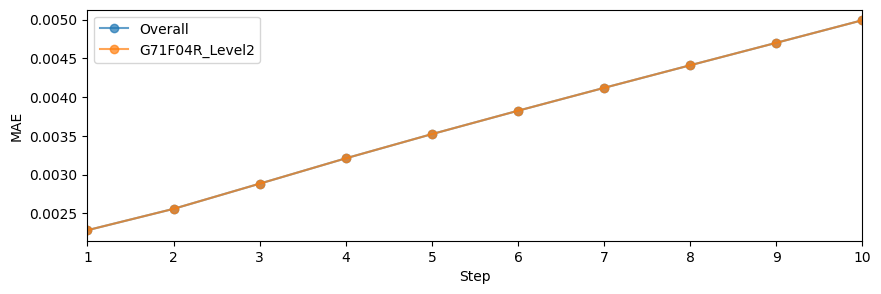

In [46]:
visualize_steps_ahead(step_MAEs)

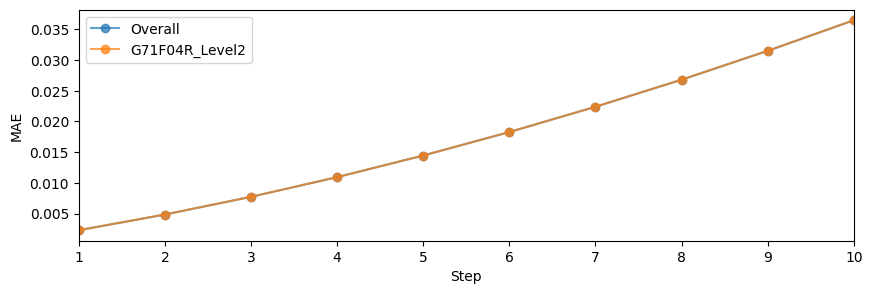

In [47]:
# cumulative
cumulative_MAE = step_MAEs.cumsum()
visualize_steps_ahead(cumulative_MAE)

In [48]:
def visualize_condition_MAE(condition_MAEs):
    # Reset index for plotting
    _condition_MAE = condition_MAEs.reset_index()
    # Pivot the data to have conditions as columns
    _condition_MAE = _condition_MAE.pivot(index='Step', columns='Condition', values='Overall')
    # Plot each condition
    fig, ax = plt.subplots(figsize=(10, 3))
    for condition_name in _condition_MAE.columns:
        _condition_MAE[condition_name].plot(kind='line', marker='o', ax=ax, color=condition_to_meta[condition_name]['color'], alpha=0.7)    

    # Add labels and title
    plt.xlabel('Step')
    plt.ylabel('MAE')
    plt.xlim(min(_condition_MAE.index), max(_condition_MAE.index))
    plt.legend(title='Condition')
    plt.show()


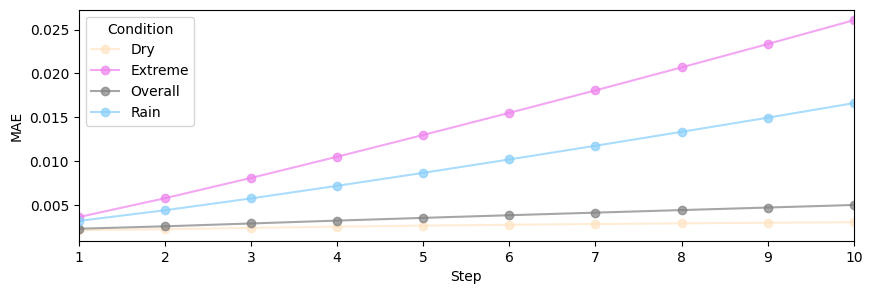

In [49]:
visualize_condition_MAE(condition_MAEs)

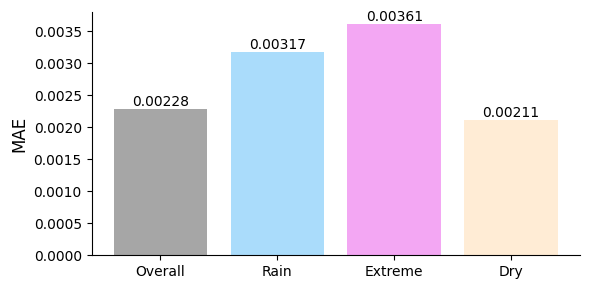

In [50]:
fig, ax = plt.subplots(figsize=(6, 3))
condition_names = condition_MAEs.index.get_level_values(1).unique()
for (_, row), condition_name in zip(condition_MAEs[['Overall']].head(4).iterrows(), condition_names):
    ax.bar(condition_name, row['Overall'], color=condition_to_meta[condition_name]['color'], label=condition_name, alpha=0.7)
    # add text to the bar
    ax.text(condition_name, row['Overall'], f"{row['Overall']:.5f}", ha='center', va='bottom')
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.set_ylabel('MAE', fontsize=12)
plt.tight_layout()
plt.show()

## Visualize

In [51]:
def visualize_prediction(target, independent, pred_timestamps, prediction):

    # 2 subplots; rain, sensor
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    ##############################
    # Rain data; constant
    ##############################
    # visualize exo data with colormap cool
    for inendogenous_var in independent.columns:
        color = rain_gauge_color.get(inendogenous_var, 'blue')
        axs[0].plot(independent[inendogenous_var], label=inendogenous_var, color=color, linewidth=1, linestyle='-', marker='o', markersize=1, alpha=1)
    
    axs[0].set_title('Rain data', fontsize=12); axs[0].set_ylabel('Rain (mm)'); axs[0].legend(loc='upper left')

    ##############################
    # Sensor data; variable
    ##############################
    # visualize target data
    axs[1].plot(target, label='Target', linewidth=1, linestyle='-', marker='o', markersize=1, alpha=1)
    # prediction
    axs[1].plot(pred_timestamps, prediction, label='Prediction', linewidth=1, linestyle='-', marker='o', markersize=1, alpha=1)
    # visualize
    axs[1].set_title('Sensor data', fontsize=12); axs[1].set_ylabel('unit, TODO'); axs[1].legend(loc='upper left')

    ##############################
    # Format
    ##############################
    # Set x lim to the start and end of the event
    axs[-1].set_xlim(target.index[0], target.index[-1])
    set_meaningful_xticks(axs[-1], target.index[0], target.index[-1])

    return fig, axs


def visualize_condition_events(example_folder, model, dataset, data, 
        conditions, steps_ahead, scalers,
        n_events_per_condition=2,
        n_starts_per_event=5,
        save_plots=True,
        ):

    # Extract the relevant indices
    valid_timestamps = dataset.valid_timestamps

    # Define event period to visualize
    look_back_min = dataset.sequence_length
    look_forward_min = 60 + steps_ahead # 1 hour ahead

    # iterate over the conditions
    for condition_name, condition_data in conditions.items():
        if condition_name == 'Overall':
            continue
        
        print("#"*50)
        print(f"Visualizing condition: {condition_name}")
        print("#"*50)
        # sample the first period
        events = condition_data['df'].head(n_events_per_condition)
        
        # iterate over the events
        for _, event in events.iterrows():
            
            # Get the prediction indices
            start, end = event['start'], event['start']+pd.Timedelta(hours=3) # from start and to start + 3 hours for fixed duration
            event_timestamps = pd.date_range(start, end, freq='1min')
            relevant_indices = np.where(np.isin(valid_timestamps, event_timestamps))[0]
            prediction_indices = relevant_indices[::len(relevant_indices)//n_starts_per_event]

            # Get the plot data
            start = (pd.to_datetime(start) - pd.Timedelta(minutes=look_back_min)).floor('1h')
            end = (pd.to_datetime(end) + pd.Timedelta(minutes=look_forward_min)).ceil('1h')
            event_data = data.loc[start:end]

            for i, endogenous_var in enumerate(dataset.endogenous_vars):
                # Create a folder for each sensor
                sensor_folder = example_folder / endogenous_var
                os.makedirs(sensor_folder, exist_ok=True)

                for idx, i in enumerate(prediction_indices):
                    # Get the prediction
                    #pred_timestamps = valid_timestamps[i:i+steps_ahead]
                    pred_timestamps = pd.date_range(valid_timestamps[i], periods=steps_ahead, freq='1min')
                    valid_idx = dataset.valid_indices[i]
                    prediction, _ = predict(model, i, valid_idx, dataset, steps_ahead, scalers)

                    # Visualize
                    fig, ax = visualize_prediction(event_data[endogenous_var], event_data[dataset.exogenous_vars], pred_timestamps, prediction)
                    start_str = start.strftime("%Y-%m-%d")
                    if save_plots:
                        fig.savefig(sensor_folder / f'{condition_name}_{start_str}_{idx+1}.png')
                        plt.close(fig)
                    else:
                        plt.show()
                


In [58]:
data_type = 'test'

In [59]:
# load the model
model_to_load = 'best_model_path' # ['best_model_path', 'last_model_path']
model = load_model_checkpoint(run_folder, run_info, model_to_load, config)

Using CPU
Model loaded from /work3/s194262/GitHub/fault_management_uds/models/1_model_complexity/hidden_size=128_num_heads=2_num_layers=2_241221_1952/1_split/epoch=13-val_loss=0.0000134.ckpt


In [60]:
# load the data
scalers = run_info['dataset_config']['scalers']
data = load_data([None, None], config['dataset_args']['data_file_path'], config['dataset_args'], data_type='complete')
# get the dataset
dataset = get_sensor_dataset(data, config['dataset_args'], 
    data_idx=run_info['dataset_config'][f'{data_type}_index'], 
    scalers=scalers,
    priority_weight=None, verbose=False, dataset_type=data_type)
# load the conditions
starttime, endtime = dataset.valid_timestamps[0], dataset.valid_timestamps[-1]
conditions = load_conditions(starttime, endtime)


##################################################
Visualizing condition: Rain
##################################################


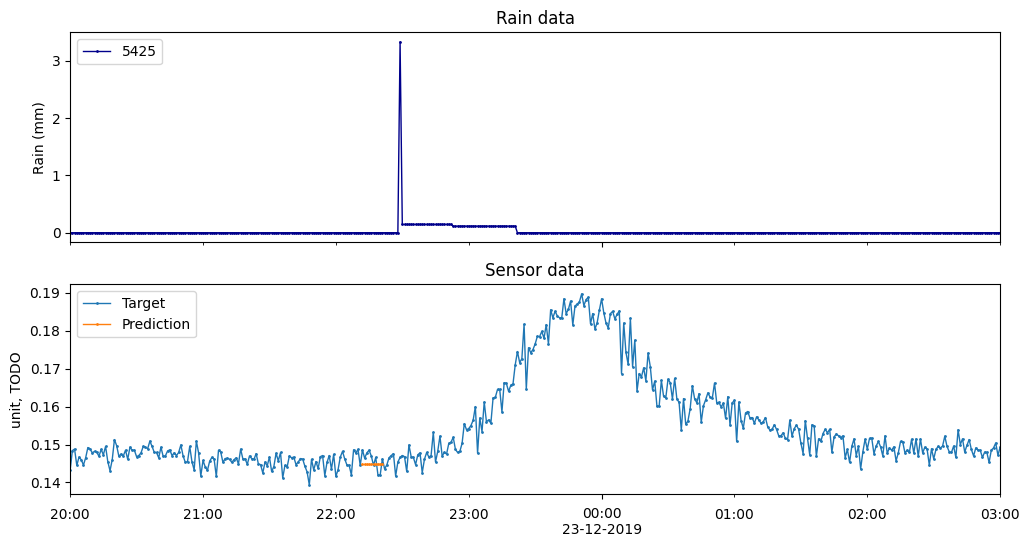

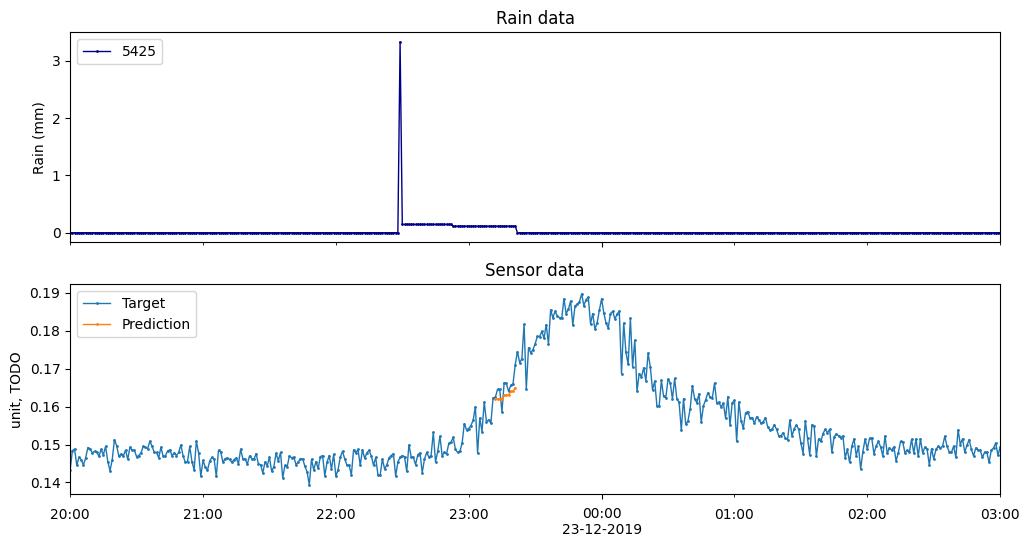

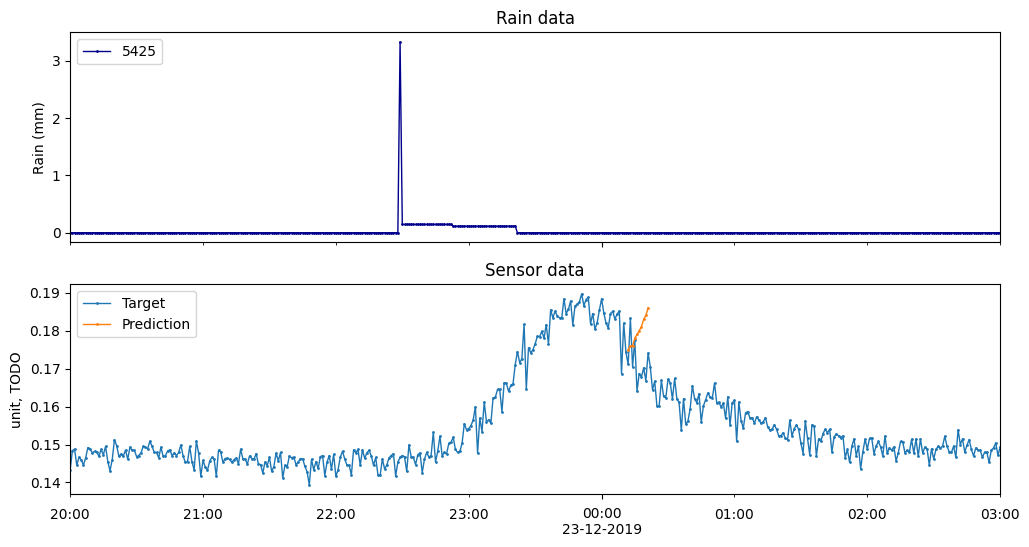

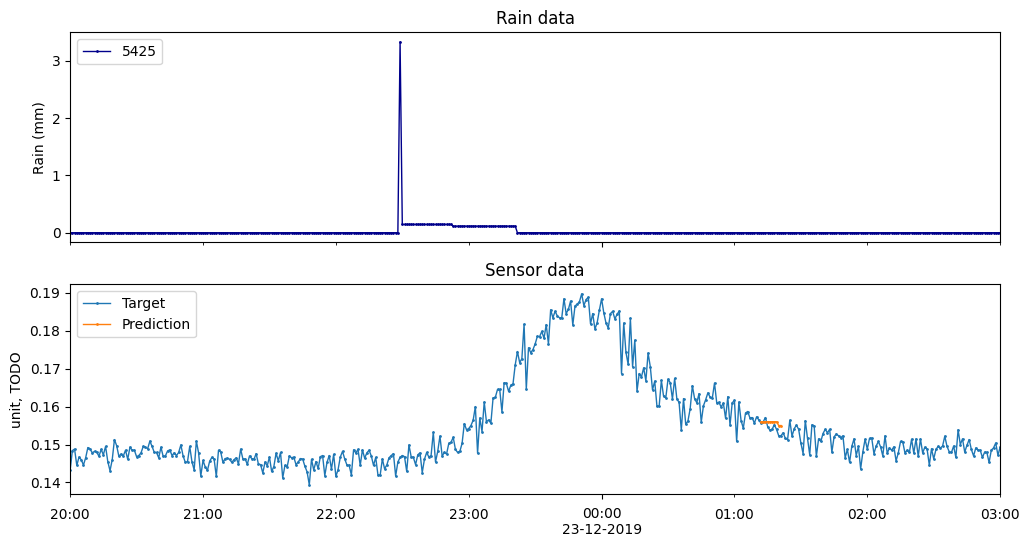

##################################################
Visualizing condition: Extreme
##################################################


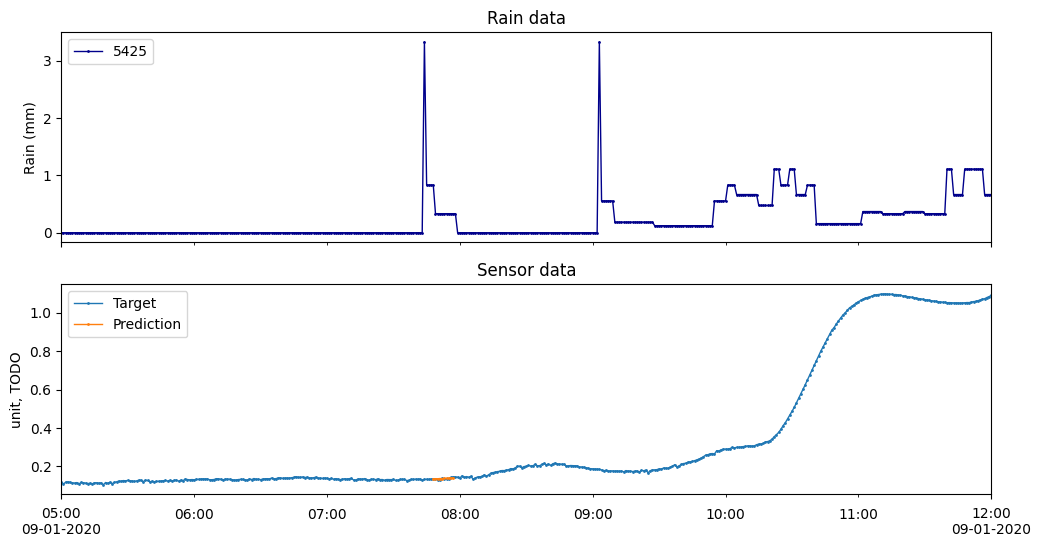

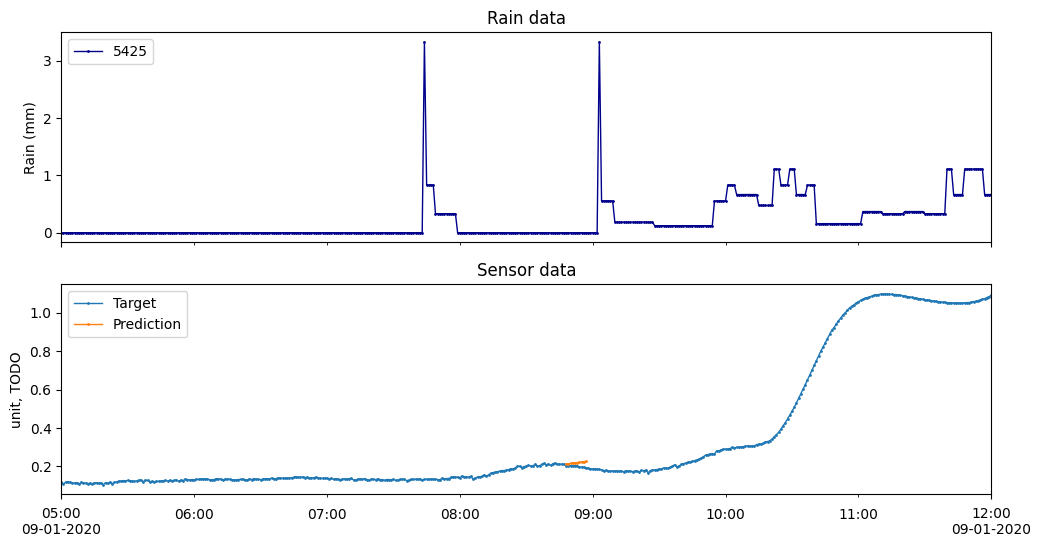

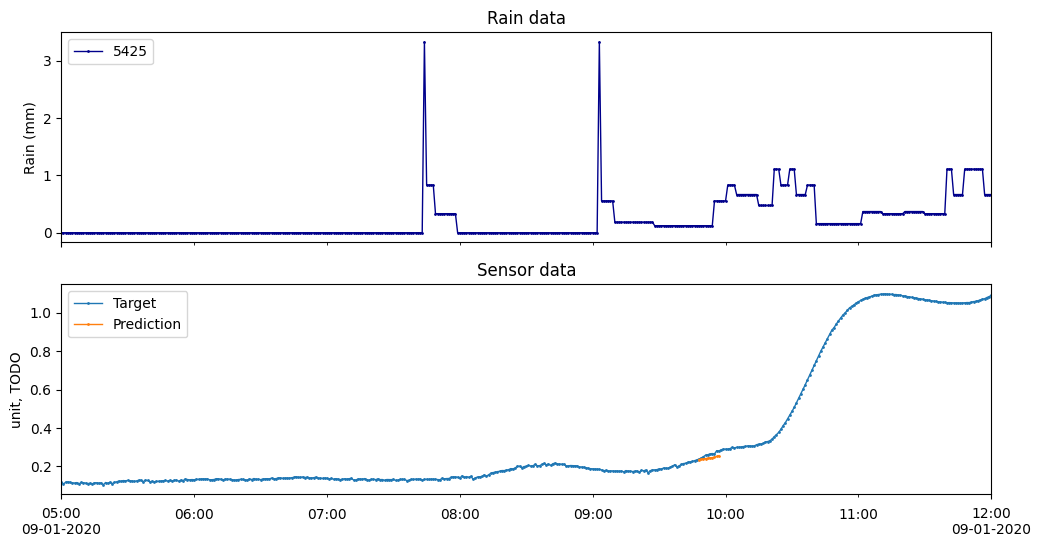

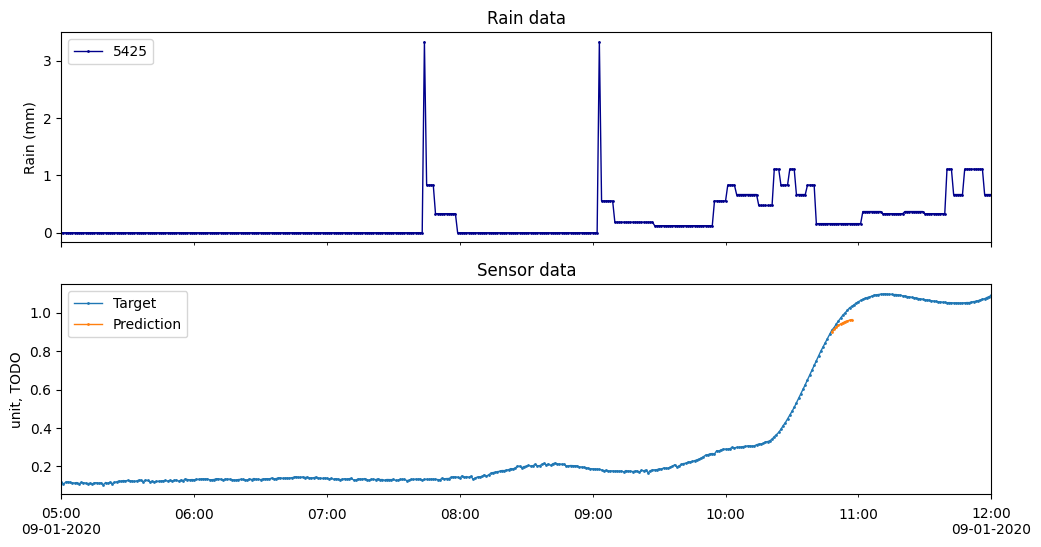

##################################################
Visualizing condition: Dry
##################################################


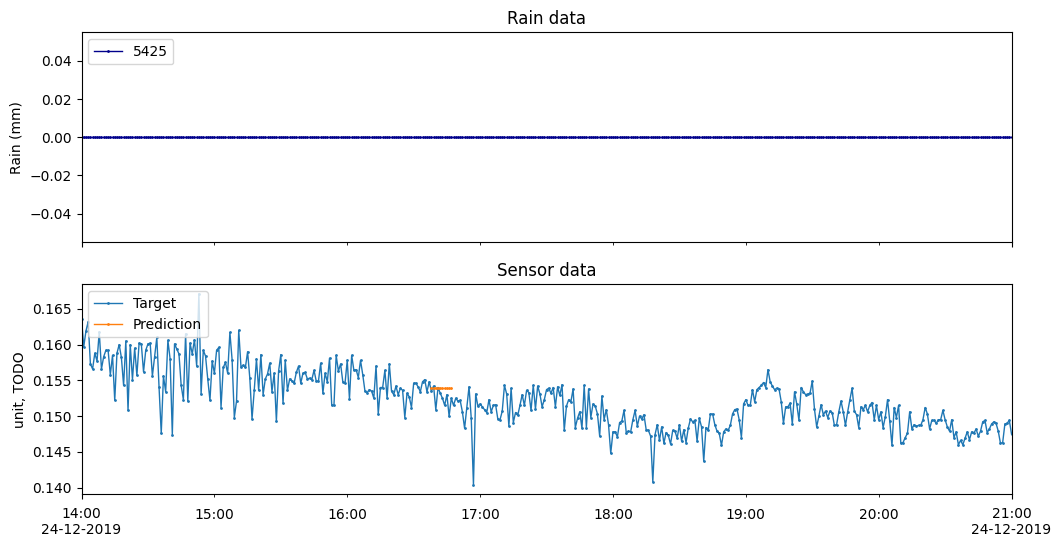

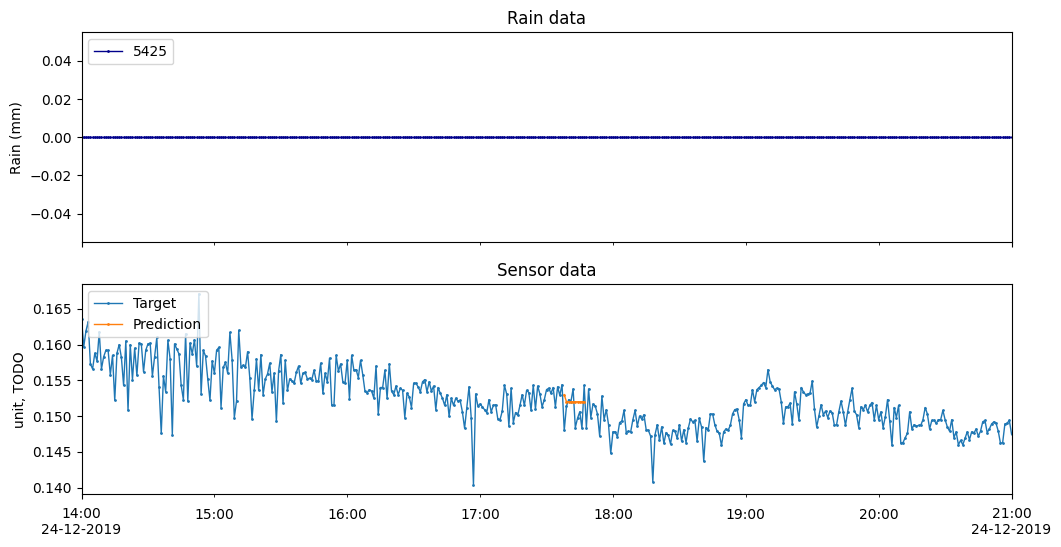

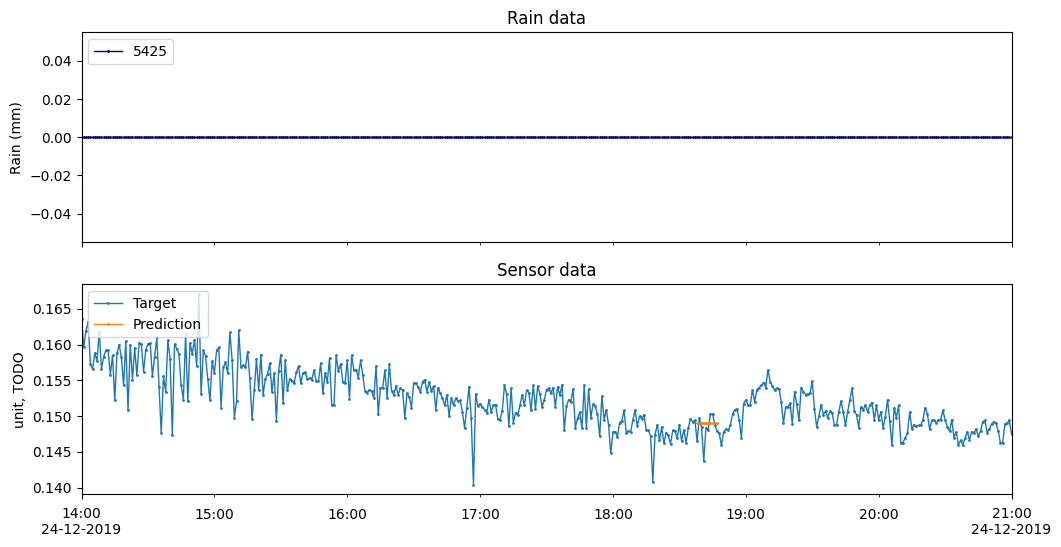

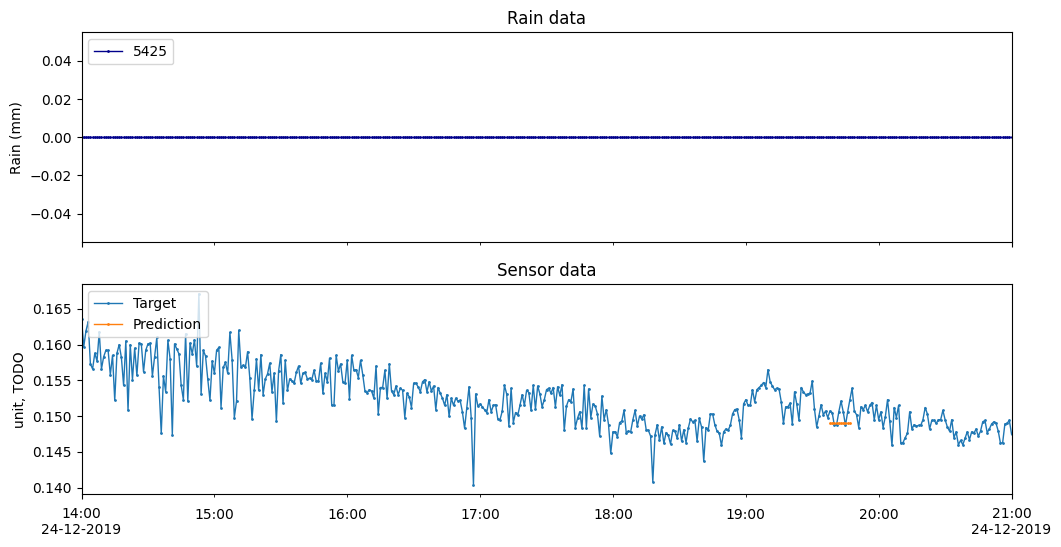

In [61]:

example_folder = eval_folder / data_type / 'examples'
# os.makedirs(example_folder, exist_ok=True)

visualize_condition_events(example_folder, model, dataset, data, conditions, 
        config['predict_steps_ahead'], 
        scalers,
        n_events_per_condition=1,
        n_starts_per_event=3,
        save_plots=False,
        )